In [1]:
import gymnasium as gym
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 行動選択と学習のアルゴリズム
def epsilon_greedy(Q_s, eps=0.1):
    p = random.random()
    if p < eps:
        return random.randrange(len(Q_s))
    return Q_s.argmax()

def Q_learning(Q, s, a, r, s_, alpha=0.5, gamma=1.0):
    Q[s][a] += alpha * (r + gamma * Q[s_].max() - Q[s][a])
    return Q

def sarsa(Q, s, a, r, s_, a_, alpha=0.5, gamma=1.0):
    Q[s][a] += alpha * (r + gamma * Q[s_][a_] - Q[s][a])
    return Q

# 方策の可視化
def policy_at_location(s, Q):
    inv_temp = 1
    qs = Q[s]
    d4 = np.exp(inv_temp * (qs - qs.max()))
    d4 /= max(0.1, d4.sum())
    actions = [(-1, 0), (0, 1), (1, 0), (0, -1)] # 上、右、下、左
    return d4 @ actions

def visualize_policy(Q):
    X, Y = np.meshgrid(np.linspace(0, 11, 12), np.linspace(0, 3, 4))
    pos = np.dstack((Y, X))
    uv = np.zeros_like(pos)
    for s in range(48):
        uv[s // 12, s % 12] = policy_at_location(s, Q)
    U = uv[:, :, 0]
    V = uv[:, :, 1]
    _, ax = plt.subplots()
    ax.invert_yaxis()
    ax.quiver(X, Y, V, U, angles='xy', scale_units='xy', scale=1)
    ax.set_aspect('equal')
    return ax

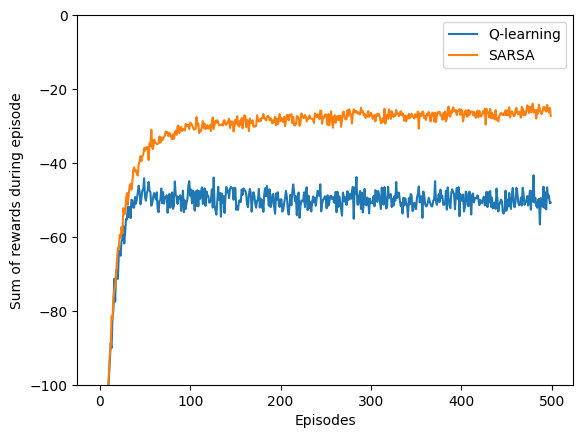

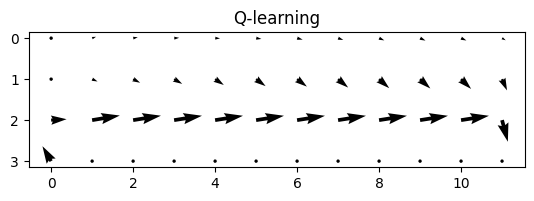

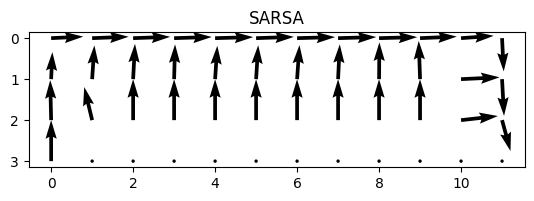

In [ ]:
# 実験
env = gym.make("CliffWalking-v0")
n = 1000 # 1000回実験して平均を取る
num_episodes = 500
mean_g_q = [0] * num_episodes # エピソードごとの累積報酬(Q学習)
mean_g_sarsa = [0] * num_episodes # エピソードごとの累積報酬(SARSA)
mean_Q_q = np.zeros((48, 4)) # Qテーブル(Q学習)
mean_Q_sarsa = np.zeros((48, 4)) # Qテーブル(SARSA)
for i in range(n):
    # Qテーブルの初期化
    Q_q = np.zeros((48, 4))
    Q_sarsa = np.zeros((48, 4))
    for episode in range(num_episodes):
        # Q学習
        g = 0 # 累積報酬
        terminated = truncated = False
        s, _ = env.reset()
        while not (terminated or truncated):
            a = epsilon_greedy(Q_q[s]) # 行動選択
            s_, r, terminated, truncated, _ = env.step(a)
            Q_q = Q_learning(Q_q, s, a, r, s_) # 学習
            s = s_
            g += r
        mean_g_q[episode] = (mean_g_q[episode] * i + g) / (i + 1)
        # SARSA
        g = 0
        terminated = truncated = False
        s, _ = env.reset()
        a = epsilon_greedy(Q_sarsa[s])
        while not (terminated or truncated):
            s_, r, terminated, truncated, _ = env.step(a)
            a_ = epsilon_greedy(Q_sarsa[s_]) # 行動選択
            Q_sarsa = sarsa(Q_sarsa, s, a, r, s_, a_) # 学習
            s = s_
            a = a_
            g += r
        mean_g_sarsa[episode] = (mean_g_sarsa[episode] * i + g) / (i + 1)
    # 最終エピソードのQテーブルを記録
    mean_Q_q = (mean_Q_q * i + Q_q) / (i + 1)
    mean_Q_sarsa = (mean_Q_sarsa * i + Q_sarsa) / (i + 1)
env.close()
# episode return
plt.plot(mean_g_q, label="Q-learning")
plt.plot(mean_g_sarsa, label="SARSA")
plt.legend()
plt.ylim(-100, 0)
plt.xlabel("Episodes")
plt.ylabel("Sum of rewards during episode")
plt.show()
# policy visualization
visualize_policy(mean_Q_q)
plt.title("Q-learning")
plt.show()
visualize_policy(mean_Q_sarsa)
plt.title("SARSA")
plt.show()

ε-greedyで行動を選択しているので、正しく学習しても崖に落ちることがある。Q学習は価値関数の更新にmax(Q(s',a))を使うので最短経路を学習できるが、その結果崖に落ちやすくなる。SARSAは価値関数の更新にQ(s',a')を使うので崖に落ちにくい経路を学習でき、Q学習よりも少ない減点でゴールできるようになる。